## Read me
>   This program can extract tof spectrum from a specific ROI

> The h5 file is generated by the following command in my enviroment. I used Sphiread v2.0.0.

/SNS/users/uff/mcpevent2hist/sophiread/build/Sophiread -i /SNSlocal/data/IPTS-34969/raw_tpx3/Run_8217_April25_2025_Ni_Powder_MCP_TPX3_0_8C_1_9_AngsMin_serval_000000.tpx3 -H /SNSlocal/data/uff/Sophiread_test/Bragg_edge_analysis/Data_analyzed_by_Shimin/Run_8217/Run_8217_April25_2025_Ni_Powder_MCP_TPX3_0_8C_1_9_AngsMin_serval_000000_hits_old_sophiread.h5

The produced h5 file was analyzed with the following python code.

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path

# Define functions

In [2]:
def process_into_hyperspectra(x, y, tof_ns,
                              num_tof_bins=1500,
                              tof_range_s=(1.0, 1/60.0),
                              x_range=None, y_range=None):
    """
    Bin hits into a 3D “hyperspectra” array of shape (tof, x, y)
    using a one-shot np.histogramdd call.

    Parameters
    ----------
    x, y : array-like of ints
        Detector pixel coordinates for each hit.
    tof_ns : array-like of floats
        Time-of-flight for each hit, in nanoseconds.
    num_tof_bins : int
        Number of TOF bins.
    tof_range_s : tuple(float, float)
        (t_min, t_max) in seconds over which to bin TOF.
    x_range, y_range : tuple(int, int), optional
        (min, max) pixel indices.  If None, inferred from data.

    Returns
    -------
    H : ndarray, shape (num_tof_bins, n_x, n_y)
        Hyperspectra cube: counts[b, i, j] is the number of hits
        in TOF-bin b at pixel (x_i, y_j).
    tof_edges_ns : ndarray, shape (num_tof_bins+1,)
        Edges of the TOF bins in nanoseconds.
    x_edges, y_edges : ndarrays
        Bin edges along x and y (length n_x+1, n_y+1).
    """
    # 1) Build TOF bin edges (convert seconds→ns)
    t_min_s, t_max_s = tof_range_s
    tof_edges_ns = np.linspace(t_min_s * 1e9,
                               t_max_s * 1e9,
                               num_tof_bins + 1)

    # 2) Determine x/y edges
    if x_range is None:
        x_min, x_max = int(x.min()), int(x.max())
    else:
        x_min, x_max = x_range
    if y_range is None:
        y_min, y_max = int(y.min()), int(y.max())
    else:
        y_min, y_max = y_range

    # We add +1 so that an integer pixel i in [x_min..x_max]
    # falls into bin i−x_min
    x_edges = np.arange(x_min, x_max + 2)
    y_edges = np.arange(y_min, y_max + 2)

    # 3) Stack into (N, 3) points array
    pts = np.vstack([x, y, tof_ns]).T

    # 4) One‐shot histogramdd: result shape = (nx, ny, nt)
    H3, edges = np.histogramdd(
        pts,
        bins=(x_edges, y_edges, tof_edges_ns)
    )

    # 5) Reorder axes → (nt, nx, ny)
    H = H3.transpose(2, 0, 1).astype(int)

    return H, tof_edges_ns, x_edges, y_edges
# H, tof_edges, x_edges, y_edges = process_into_hyperspectra(
#     x_array, y_array, tof_ns,
#     num_tof_bins=1500,
#     tof_range_s=(0, 1/60.0)
# )


In [3]:
def plot_image_with_roi(image2d, roi, cmap="gray", origin="lower"):
    """
    Display a 2D image and overlay a rectangular ROI.

    Parameters
    ----------
    image2d : 2D array
        The image to show, e.g. H[bin_index,:,:] or H.sum(axis=0).
    roi : tuple (x_low, x_high, y_low, y_high)
        Inclusive pixel bounds of the ROI.
    cmap : str
        Matplotlib colormap name.
    origin : {"upper","lower"}
        Image origin.
    """
    x_low, x_high, y_low, y_high = roi
    width  = x_high - x_low + 1
    height = y_high - y_low + 1

    fig, ax = plt.subplots()
    im=ax.imshow(image2d, cmap=cmap, origin=origin)
    # Create a Rectangle patch: (x_low, y_low) is the lower‐left corner
    rect = Rectangle(
        (y_low, x_low),
        height, width,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)
    ax.set_xlabel("X pixel")
    ax.set_ylabel("Y pixel")
    # Add a colorbar
    cbar = fig.colorbar(im)
    im.set_clim(0, 1E2) 
    
    ax.set_title(f"Image with ROI {roi}")
    plt.show()

# roi = 50, 500,170, 350

# plot_image_with_roi(H[0], roi)

In [4]:
def extract_tof_spectrum_roi(
    hyperspectra: np.ndarray,
    roi: tuple[int, int, int, int]
) -> np.ndarray:
    """
    Extract the TOF spectrum by summing counts within a rectangular ROI.

    Parameters
    ----------
    hyperspectra : ndarray, shape (n_tof, n_x, n_y)
        The 3D histogram of counts.
    roi : tuple (x_low, x_high, y_low, y_high)
        Inclusive pixel boundaries for the ROI.

    Returns
    -------
    tof_spectrum : ndarray, shape (n_tof,)
        Summed counts per TOF bin over the specified ROI.
    """
    x_low, x_high, y_low, y_high = roi
    # Clip to valid index range
    n_tof, n_x, n_y = hyperspectra.shape
    x_low = max(0, x_low)
    x_high = min(n_x - 1, x_high)
    y_low = max(0, y_low)
    y_high = min(n_y - 1, y_high)

    # Sum over x and y within ROI
    roi_cube = hyperspectra[:, x_low:x_high+1, y_low:y_high+1]
    tof_spectrum = roi_cube.sum(axis=(1, 2))
    return tof_spectrum

# tof_spectrum_Ni = extract_tof_spectrum_roi(H, roi)

In [6]:
def process_into_hyperspectra(x, y, tof_ns,
                              num_tof_bins=1500,
                              tof_range_s=(1.0, 1/60.0),
                              x_range=None, y_range=None):
    """
    Bin hits into a 3D “hyperspectra” array of shape (tof, x, y)
    using a one-shot np.histogramdd call.

    Parameters
    ----------
    x, y : array-like of ints
        Detector pixel coordinates for each hit.
    tof_ns : array-like of floats
        Time-of-flight for each hit, in nanoseconds.
    num_tof_bins : int
        Number of TOF bins.
    tof_range_s : tuple(float, float)
        (t_min, t_max) in seconds over which to bin TOF.
    x_range, y_range : tuple(int, int), optional
        (min, max) pixel indices.  If None, inferred from data.

    Returns
    -------
    H : ndarray, shape (num_tof_bins, n_x, n_y)
        Hyperspectra cube: counts[b, i, j] is the number of hits
        in TOF-bin b at pixel (x_i, y_j).
    tof_edges_ns : ndarray, shape (num_tof_bins+1,)
        Edges of the TOF bins in nanoseconds.
    x_edges, y_edges : ndarrays
        Bin edges along x and y (length n_x+1, n_y+1).
    """
    # 1) Build TOF bin edges (convert seconds→ns)
    t_min_s, t_max_s = tof_range_s
    tof_edges_ns = np.linspace(t_min_s * 1e9,
                               t_max_s * 1e9,
                               num_tof_bins + 1)

    # 2) Determine x/y edges
    if x_range is None:
        x_min, x_max = int(x.min()), int(x.max())
    else:
        x_min, x_max = x_range
    if y_range is None:
        y_min, y_max = int(y.min()), int(y.max())
    else:
        y_min, y_max = y_range

    # We add +1 so that an integer pixel i in [x_min..x_max]
    # falls into bin i−x_min
    x_edges = np.arange(x_min, x_max + 2)
    y_edges = np.arange(y_min, y_max + 2)

    # 3) Stack into (N, 3) points array
    pts = np.vstack([x, y, tof_ns]).T

    # 4) One‐shot histogramdd: result shape = (nx, ny, nt)
    H3, edges = np.histogramdd(
        pts,
        bins=(x_edges, y_edges, tof_edges_ns)
    )

    # 5) Reorder axes → (nt, nx, ny)
    H = H3.transpose(2, 0, 1).astype(int)

    return H, tof_edges_ns, x_edges, y_edges

# H, tof_edges, x_edges, y_edges = process_into_hyperspectra(
#     x_array, y_array, tof_ns,
#     num_tof_bins=1500,
#     tof_range_s=(0, 1/60.0)
# )

In [ ]:
# Set ROI
roi = 300, 450,300, 450

In [8]:
# Ni data
data_root = Path("/SNSlocal/data/uff/Sophiread_test/Bragg_edge_analysis/Data_analyzed_by_Shimin/Run_8223")
h5_filename = "Run_8223_April25_2025_Ni_Powder_MCP_TPX3_2_4C_1_9_AngsMin_serval_000000_hits_old_sophiread.h5"
h5file = data_root / h5_filename

Extract all hist from HDF5 archive for processing

In [9]:
with h5py.File(h5file) as h5f:
    x_array = h5f["hits/x"][:]
    y_array = h5f["hits/y"][:]
    tof_ns = h5f["hits/tof_ns"][:]
    spidertime_ns = h5f["hits/spidertime_ns"][:]

In [10]:
H, tof_edges, x_edges, y_edges = process_into_hyperspectra(
    x_array, y_array, tof_ns,
    num_tof_bins=1500,
    tof_range_s=(0, 1/60.0)
)

In [11]:
H.shape

(1500, 516, 516)

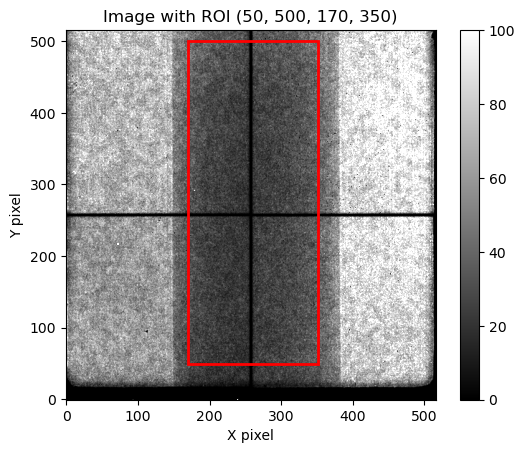

In [33]:
# Check 2D image
plot_image_with_roi(H[0], roi)

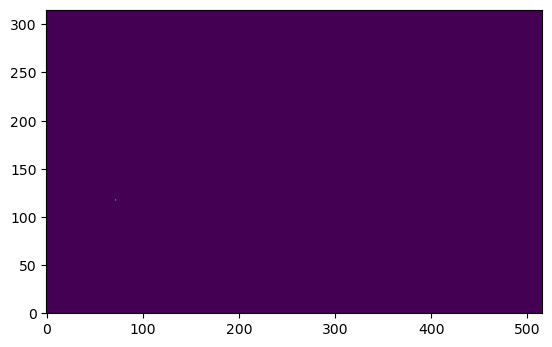

In [34]:
plt.imshow(H[0, 100:-100, :], origin="lower")

this tells us

- dim_0: TOF dimension
- dim_1: row index
- dim_2: col index

In [35]:
tof_spectrum_Ni = extract_tof_spectrum_roi(H, roi)

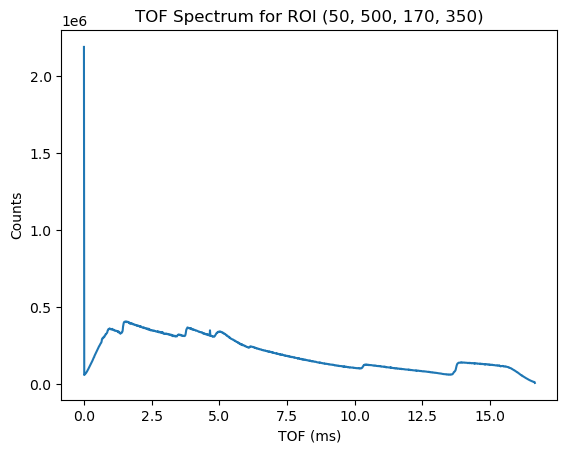

In [36]:
plt.plot(tof_edges[:-1]/1e6, tof_spectrum_Ni)  # Anton Tremsin likes to use the beginning of the edge to represent the bin
plt.xlabel('TOF (ms)')
plt.ylabel('Counts')
plt.title(f'TOF Spectrum for ROI {roi}')
plt.show()

# Get all tof data of direct beam

In [40]:
data_root = Path("/SNSlocal/data/uff/Sophiread_test/Bragg_edge_analysis/Data_analyzed_by_Shimin/Run_8222")
h5_filename_1 = "Run_8222_April25_2025_OB_MCP_TPX3_2_4C_1_9_AngsMin_serval_000000_part001.h5"
h5file_1 = data_root / h5_filename_1

h5_filename_2 = "Run_8222_April25_2025_OB_MCP_TPX3_2_4C_1_9_AngsMin_serval_000000_part002.h5"
h5file_2 = data_root / h5_filename_2

h5_filename_3 = "Run_8222_April25_2025_OB_MCP_TPX3_2_4C_1_9_AngsMin_serval_000000_part003.h5"
h5file_3 = data_root / h5_filename_3




In [41]:
with h5py.File(h5file_1) as h5f:
    x_array_1 = h5f["hits/x"][:]
    y_array_1 = h5f["hits/y"][:]
    tof_ns_1 = h5f["hits/tof_ns"][:]
    
    
with h5py.File(h5file_2) as h5f:
    x_array_2 = h5f["hits/x"][:]
    y_array_2 = h5f["hits/y"][:]
    tof_ns_2 = h5f["hits/tof_ns"][:]
    
with h5py.File(h5file_3) as h5f:
    x_array_3 = h5f["hits/x"][:]
    y_array_3 = h5f["hits/y"][:]
    tof_ns_3 = h5f["hits/tof_ns"][:]
    # spidertime_ns = h5f["hits/spidertime_ns"][:]

In [42]:
# save data for each direct beam measurements

H_1, tof_edges, x_edges, y_edges = process_into_hyperspectra(
    x_array_1, y_array_1, tof_ns_1,
    num_tof_bins=1500,
    tof_range_s=(0, 1/60.0)
)

H_2, tof_edges, x_edges, y_edges = process_into_hyperspectra(
    x_array_2, y_array_2, tof_ns_2,
    num_tof_bins=1500,
    tof_range_s=(0, 1/60.0)
)

H_3, tof_edges, x_edges, y_edges = process_into_hyperspectra(
    x_array_3, y_array_3, tof_ns_3,
    num_tof_bins=1500,
    tof_range_s=(0, 1/60.0)
)

In [43]:
tof_spectrum_OB_1 = extract_tof_spectrum_roi(H_1, roi)
tof_spectrum_OB_2 = extract_tof_spectrum_roi(H_2, roi)
tof_spectrum_OB_3 = extract_tof_spectrum_roi(H_3, roi)

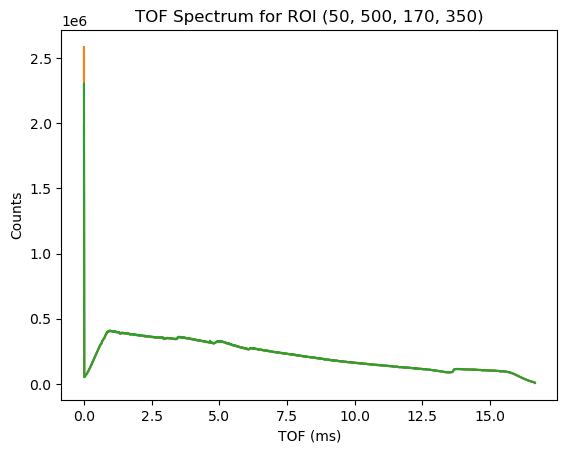

In [44]:
# checking the spectrum

plt.plot(tof_edges[:-1]/1e6, tof_spectrum_OB_1)
plt.plot(tof_edges[:-1]/1e6, tof_spectrum_OB_2)
plt.plot(tof_edges[:-1]/1e6, tof_spectrum_OB_3)# Anton Tremsin likes to use the beginning of the edge to represent the bin
plt.xlabel('TOF (ms)')
plt.ylabel('Counts')
plt.title(f'TOF Spectrum for ROI {roi}')
plt.show()

In [45]:
Total_tof_spectrum_OB=tof_spectrum_OB_1+tof_spectrum_OB_2+tof_spectrum_OB_3
Transmission= tof_spectrum_Ni /Total_tof_spectrum_OB

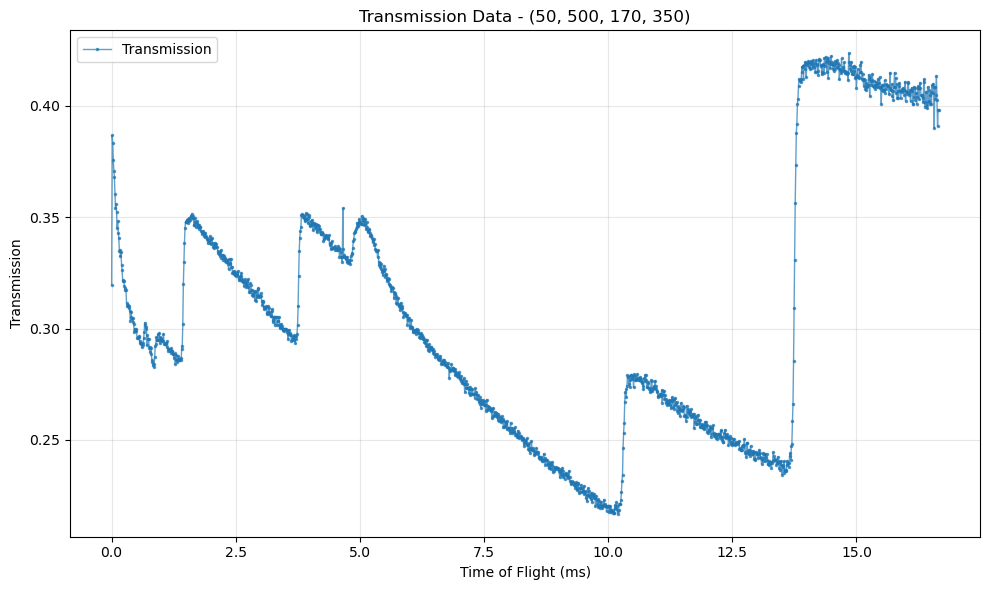

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(tof_edges[:-1]/1e6,Transmission,  label='Transmission', alpha=0.7, marker='.', markersize=3, linestyle='-', linewidth=1)
plt.xlabel('Time of Flight (ms)')
plt.ylabel('Transmission')
plt.legend()
plt.title(f'Transmission Data - {roi}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'transmission_data_{roi}.png', dpi=300)
plt.show()

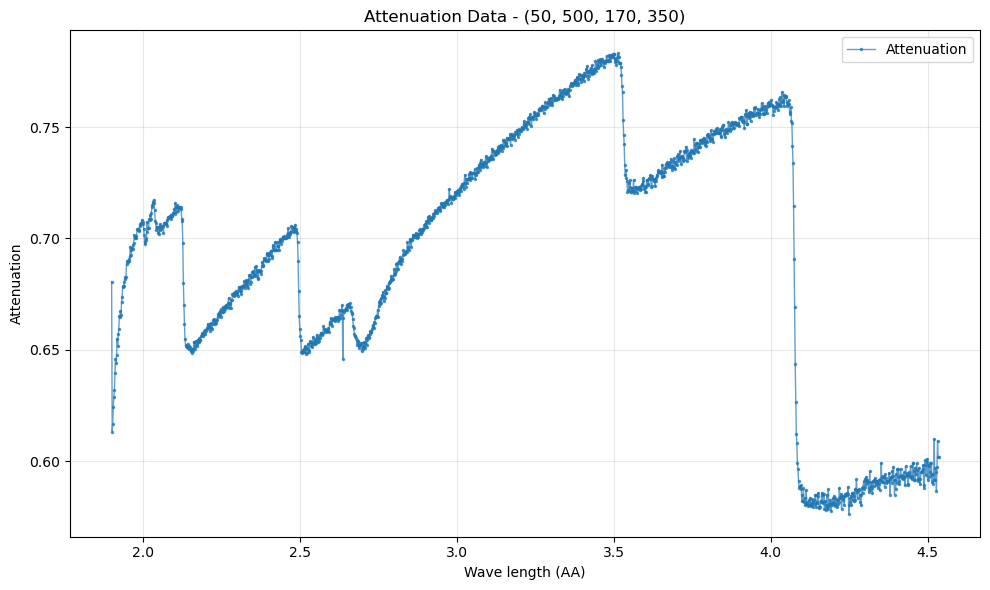

In [47]:
delay = 12005 # us
distance = 2500 
wave_tpx3 = 0.3956*(delay + (tof_edges[:-1]/1e6)*1e3)/distance

plt.figure(figsize=(10, 6))
# plt.errorbar(wave_tpx3, 1-Transmission, yerr=Transmission_error, label='Attenuation', alpha=0.7, marker='.', markersize=3, linestyle='-', linewidth=1)
plt.plot(wave_tpx3, 1-Transmission,  label='Attenuation', alpha=0.7, marker='.', markersize=3, linestyle='-', linewidth=1)
plt.xlabel('Wave length (AA)')
plt.ylabel('Attenuation')
plt.legend()
plt.title(f'Attenuation Data - {roi}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'At_wave_data_transmission_data_{roi}.png', dpi=300)
plt.show()

In [49]:
tof_data=np.stack([wave_tpx3, 1-Transmission], axis=1)

np.savetxt(f't_wave_data_attenuation_data_{roi}_{h5_filename}.txt', tof_data, delimiter='\t')

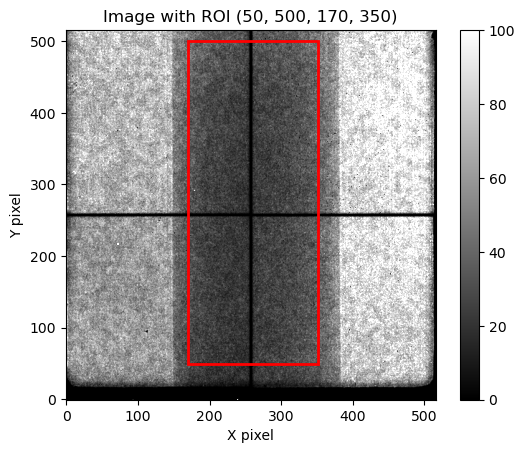

In [48]:
# def plot_image_with_roi(image2d, roi, cmap="gray", origin="lower"):
#     """
#     Display a 2D image and overlay a rectangular ROI.

#     Parameters
#     ----------
#     image2d : 2D array
#         The image to show, e.g. H[bin_index,:,:] or H.sum(axis=0).
#     roi : tuple (x_low, x_high, y_low, y_high)
#         Inclusive pixel bounds of the ROI.
#     cmap : str
#         Matplotlib colormap name.
#     origin : {"upper","lower"}
#         Image origin.
#     """
#     x_low, x_high, y_low, y_high = roi
#     width  = x_high - x_low + 1
#     height = y_high - y_low + 1

#     fig, ax = plt.subplots()
#     ax.imshow(image2d, cmap=cmap, origin=origin)
#     # Create a Rectangle patch: (x_low, y_low) is the lower‐left corner
#     rect = Rectangle(
#         (y_low, x_low),
#         height, width,
#         linewidth=2, edgecolor="red", facecolor="none"
#     )
#     ax.add_patch(rect)
#     ax.set_xlabel("X pixel")
#     ax.set_ylabel("Y pixel")
#     ax.set_title(f"Image with ROI {roi}")
#     plt.show()

roi = 50, 500,170, 350

plot_image_with_roi(H[0], roi)

In [14]:
def extract_tof_spectrum_roi(
    hyperspectra: np.ndarray,
    roi: tuple[int, int, int, int]
) -> np.ndarray:
    """
    Extract the TOF spectrum by summing counts within a rectangular ROI.

    Parameters
    ----------
    hyperspectra : ndarray, shape (n_tof, n_x, n_y)
        The 3D histogram of counts.
    roi : tuple (x_low, x_high, y_low, y_high)
        Inclusive pixel boundaries for the ROI.

    Returns
    -------
    tof_spectrum : ndarray, shape (n_tof,)
        Summed counts per TOF bin over the specified ROI.
    """
    x_low, x_high, y_low, y_high = roi
    # Clip to valid index range
    n_tof, n_x, n_y = hyperspectra.shape
    x_low = max(0, x_low)
    x_high = min(n_x - 1, x_high)
    y_low = max(0, y_low)
    y_high = min(n_y - 1, y_high)

    # Sum over x and y within ROI
    roi_cube = hyperspectra[:, x_low:x_high+1, y_low:y_high+1]
    tof_spectrum = roi_cube.sum(axis=(1, 2))
    return tof_spectrum

tof_spectrum_OB = extract_tof_spectrum_roi(H, roi)

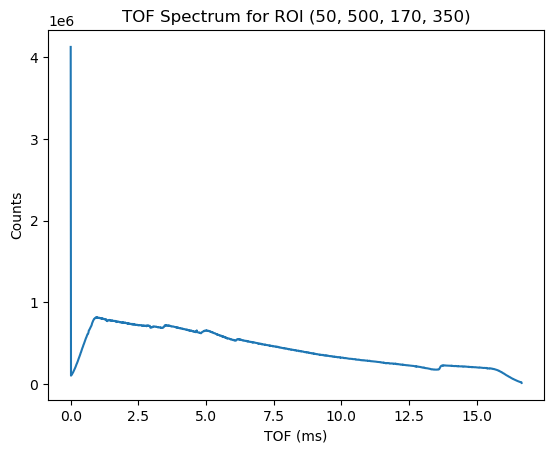

In [15]:
plt.plot(tof_edges[:-1]/1e6, tof_spectrum_OB)  # Anton Tremsin likes to use the beginning of the edge to represent the bin
plt.xlabel('TOF (ms)')
plt.ylabel('Counts')
plt.title(f'TOF Spectrum for ROI {roi}')
plt.show()

In [16]:


Transmission= tof_spectrum_Ni /tof_spectrum_OB
# Transmission_error = Transmission * np.sqrt((ni_error / ni_hits) ** 2 + (ob_error / ob_hits) ** 2)

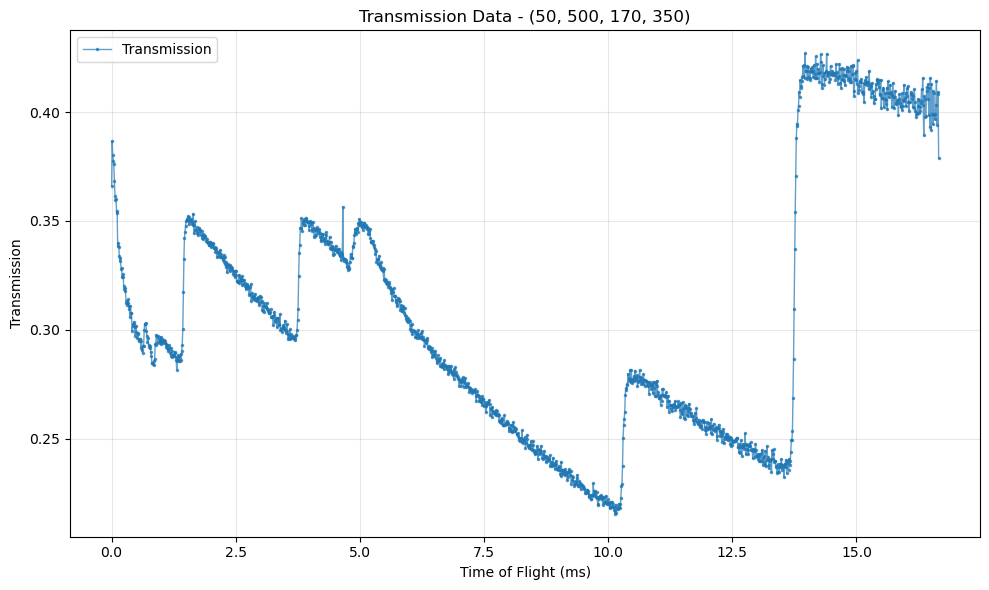

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(tof_edges[:-1]/1e6,Transmission,  label='Transmission', alpha=0.7, marker='.', markersize=3, linestyle='-', linewidth=1)
plt.xlabel('Time of Flight (ms)')
plt.ylabel('Transmission')
plt.legend()
plt.title(f'Transmission Data - {roi}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'transmission_data_{roi}.png', dpi=300)
plt.show()
    

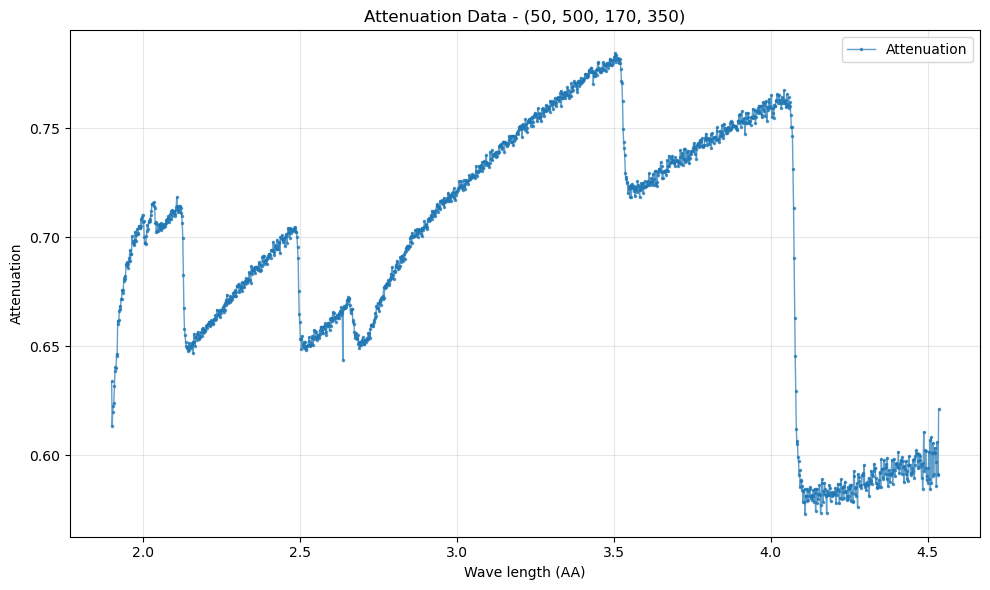

In [18]:
delay = 12005 # us
distance = 2500 
wave_tpx3 = 0.3956*(delay + (tof_edges[:-1]/1e6)*1e3)/distance

plt.figure(figsize=(10, 6))
# plt.errorbar(wave_tpx3, 1-Transmission, yerr=Transmission_error, label='Attenuation', alpha=0.7, marker='.', markersize=3, linestyle='-', linewidth=1)
plt.plot(wave_tpx3, 1-Transmission,  label='Attenuation', alpha=0.7, marker='.', markersize=3, linestyle='-', linewidth=1)
plt.xlabel('Wave length (AA)')
plt.ylabel('Attenuation')
plt.legend()
plt.title(f'Attenuation Data - {roi}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'At_wave_data_transmission_data_{roi}.png', dpi=300)
plt.show()

In [19]:
tof_data=np.stack([wave_tpx3, 1-Transmission], axis=1)

np.savetxt(f't_wave_data_attenuation_data_{roi}_{h5_filename}.txt', tof_data, delimiter='\t')
